In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import numpy as np
import pickle

sys.path.append('D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin')
from models import *
from clients_datasets import *
from tqdm.notebook import tqdm
from utils import *
from AttFunc import *
from Fisher_LeNet import *

In [77]:
batch_size = 600
epochs = 30
NC = 10
dataset = 'mnist'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 4

criterion = torch.nn.CrossEntropyLoss()

In [78]:
am = LeNet_5().cuda()
am_train(am, clients_trainloader[8], dataset)

att_type = 'unit'
acc0 = 98.88
betas = []

for i in range(10):
    beta = simulated_annealing(dataset, 1, 500, att_type, acc0, clients_testloader[8])
    betas.append(beta)
    print(beta)
beta_mean, beta_range = data_process(betas)
print('-------------------------------------')
print(beta_mean)

Training attack model:   0%|          | 0/100 [00:00<?, ?eopch/s]

1.1801381318675954
1.0546932475835455
1.2619374984977425
1.0817010189520742
0.8795480441896116
0.7934102916847317
0.8563313179490257
1.0101495515817023
0.07937564709388306
0.45440679983579024
-------------------------------------
0.8848598013512678


In [79]:
acc0 = 98.88
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 10
mode = 'Basic'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'mnist'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 4

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [3,6]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id:
                benign_params = list(client.parameters())[:2]
                mal_params = perturbation(beta=beta, bp=benign_params, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

Training:   0%|          | 0/10 [00:00<?, ?iter/s]

In [80]:
print(acc1_varying)
print(drop_varying)

[97.32, 97.57499999999997, 97.71, 97.7075, 97.814, 97.78166666666665, 97.81714285714285, 97.82874999999999, 97.8122222222222, 97.845]
[1.5599999999999965, 1.3049999999999968, 1.169999999999996, 1.1724999999999959, 1.0659999999999956, 1.0983333333333287, 1.0628571428571383, 1.0512499999999954, 1.067777777777773, 1.0349999999999953]


In [81]:
acc1_mean, acc1_range = data_process(acc1_varying)
print('acc1:')
print(acc1_mean)
print(acc1_range)
print('---------------------')
drop_mean, drop_range = data_process(drop_varying)
print('drop:')
print(drop_mean)
print(drop_range)

acc1:
97.73305555555555
0.07416666666665606
---------------------
drop:
1.14694444444444
0.07416666666666716


In [82]:
acc0 = 98.88
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 10
mode = 'Fisehr'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'mnist'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 4

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [3,6]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id :
                benign_params = list(client.parameters())[:2]

                fisher_matrix = {}
                for param_name, param in client.named_parameters():
                    if param_name == 'conv1.0.weight':
                        grad = param.grad.cpu().detach().numpy()
                        if param_name not in fisher_matrix:
                            fisher_matrix[param_name] = grad ** 2
                        else:
                            fisher_matrix[param_name] += grad ** 2
                    if param_name == 'conv1.0.bias':
                        grad = param.grad.cpu().detach().numpy()
                        if param_name not in fisher_matrix:
                            fisher_matrix[param_name] = grad ** 2
                        else:
                            fisher_matrix[param_name] += grad ** 2
                weight_positions = []
                bias_positions = []
                weight_positions.append(find_positions(fisher_matrix['conv1.0.weight'], 0.15))
                bias_positions.append(find_positions(fisher_matrix['conv1.0.bias'], 0.15))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

Training:   0%|          | 0/10 [00:00<?, ?iter/s]

In [83]:
print(acc1_varying)
print(drop_varying)

[97.15, 97.135, 96.15666666666668, 95.72999999999999, 95.13799999999999, 94.99833333333332, 95.03571428571429, 95.28375, 95.07333333333334, 94.962]
[1.7299999999999982, 1.744999999999996, 2.723333333333329, 3.149999999999996, 3.7419999999999964, 3.8816666666666624, 3.84428571428571, 3.5962499999999964, 3.806666666666663, 3.917999999999995]


In [84]:
acc1_mean, acc1_range = data_process(acc1_varying)
print('acc1:')
print(acc1_mean)
print(acc1_range)
print('---------------------')
drop_mean, drop_range = data_process(drop_varying)
print('drop:')
print(drop_mean)
print(drop_range)

acc1:
95.506875
0.44624999999999204
---------------------
drop:
3.3731249999999964
0.4462500000000005


In [85]:
acc0 = 98.88
att_type = 'unit'
acc1_varying = []
drop_varying = []
clients_acc1 = []
clients_drop = []
iters = 10
mode = 'Taylor'


for iter in tqdm(range(iters), desc="Training", unit="iter"):
    batch_size = 600
    epochs = 30
    NC = 10
    dataset = 'mnist'

    clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
    clients_testloader = load_clients_testsets(dataset, NC, batch_size)

    server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
    client_level = 1
    server_level = 4

    criterion = torch.nn.CrossEntropyLoss()
    # train
    mal_client_id = [3,6]
    server.train()
    for i in range(NC):
        clients[i].train()
    server.apply(init_weights)
    clients[0].apply(init_weights)
    last_trained_params = clients[0].state_dict()
    for epoch in range(epochs):
        beta = beta_mean
        for idx, client in enumerate(clients):
            client.load_state_dict(last_trained_params)
            for j, data in enumerate(clients_trainloader[idx]):
                # training part
                images, labels = data
                images = images.cuda()
                labels = labels.cuda()
                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                clients_opts[idx].zero_grad()
                server_opt.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                clients_opts[idx].step()
                server_opt.step()
            # weight sharing
            last_trained_params = client.state_dict()
            # attack part
            if idx in mal_client_id:
                benign_params = list(client.parameters())[:2]

                Taylor_scores = {}
                for param_name, param in client.named_parameters():
                    if param.grad is not None:
                        Taylor_scores[param_name] = torch.abs(param * param.grad)

                weight_positions = []
                bias_positions = []
                weight_positions.append(find_positions(Taylor_scores['conv1.0.weight'].cpu().detach().numpy(), 0.15))
                bias_positions.append(find_positions(Taylor_scores['conv1.0.bias'].cpu().detach().numpy(), 0.15))

                mal_params = fisher_perturbation(client_level, beta, benign_params, weight_positions, bias_positions, type=att_type)
                last_trained_params['conv1.0.weight'] = mal_params[0]
                last_trained_params['conv1.0.bias'] = mal_params[1]
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)

    # test
    server.eval()
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc1 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc1 = 100 * correct / total
            clients_acc1.append(acc1)
            drop = acc0 - acc1
            clients_drop.append(drop)
    acc1 = np.mean(clients_acc1)
    acc1_varying.append(acc1)
    drop = np.mean(clients_drop)
    drop_varying.append(drop)

Training:   0%|          | 0/10 [00:00<?, ?iter/s]

In [86]:
print(acc1_varying)
print(drop_varying)

[96.96, 95.92000000000002, 96.23666666666666, 95.5025, 94.772, 95.17666666666668, 95.4842857142857, 95.25375, 95.08555555555554, 94.764]
[1.919999999999996, 2.959999999999995, 2.6433333333333286, 3.377499999999995, 4.107999999999995, 3.7033333333333287, 3.3957142857142815, 3.626249999999996, 3.7944444444444394, 4.115999999999996]


In [87]:
acc1_mean, acc1_range = data_process(acc1_varying)
print('acc1:')
print(acc1_mean)
print(acc1_range)
print('---------------------')
drop_mean, drop_range = data_process(drop_varying)
print('drop:')
print(drop_mean)
print(drop_range)

acc1:
95.41351190476189
0.24875000000000114
---------------------
drop:
3.466488095238091
0.24875000000000114


In [88]:
x = ['Baseline', 'Attack Strategy 1', 'Attack Strategy 2', 'Attack Strategy 3']
val = {
    'Baseline': [98.88],
    'Basic': [93.14, 97.27, 96.81],
    'Fisher': [91.86, 95.65, 93.77],
    'Taylor': [87.37,  87.212, 94.32]
}


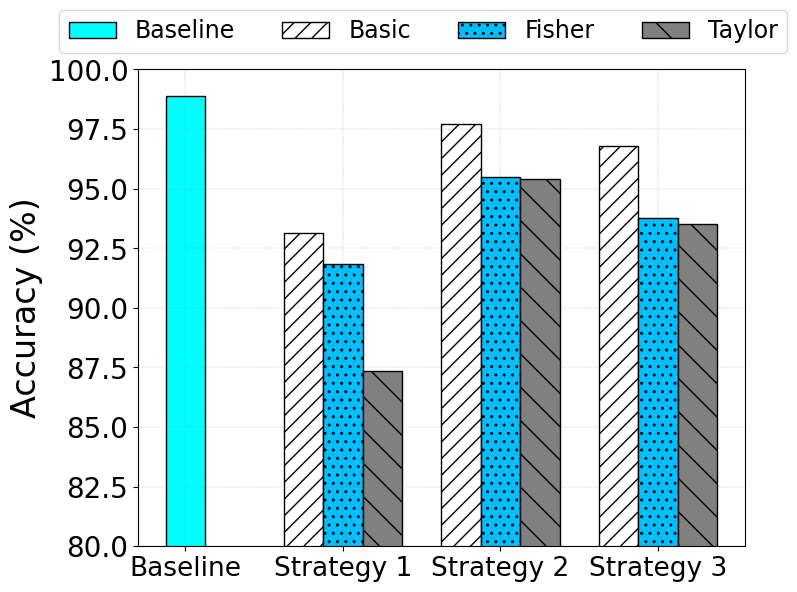

In [3]:
x = ['Baseline', 'Strategy 1', 'Strategy 2', 'Strategy 3']
val = {
    'Baseline': [98.88],
    'Basic': [93.14, 97.73, 96.81],
    'Fisher': [91.86, 95.50, 93.77],
    'Taylor': [87.37, 95.41, 93.53]
}

# 设置柱状图的宽度和 x 轴位置
bar_width = 0.25
x_positions = np.arange(len(x))

# 创建图表
fig, ax = plt.subplots(figsize=(8, 6))

# Baseline的单个柱状图
ax.bar(x_positions[0], val['Baseline'][0], width=bar_width, label='Baseline', color='cyan', edgecolor='black')

# 攻击策略的柱状图颜色和样式设置
strategies = ['Basic', 'Fisher', 'Taylor']
colors = ['white', 'deepskyblue', 'gray']
# colors = ['red', 'green', 'blue']
hatches = ['//', '..', '\\']

# 绘制每个攻击策略的柱状图
for i, strategy in enumerate(strategies):
    for j in range(3):  # 每个策略有三个值
        ax.bar(
            x_positions[j + 1] + (i - 1) * bar_width,
            val[strategy][j],
            width=bar_width,
            color=colors[i],
            edgecolor='black',
            hatch=hatches[i],
            label=strategy if j == 0 else ""  # 避免重复显示图例
        )

# 设置图例和轴标签
plt.xticks(fontsize=19)
plt.yticks(fontsize=20)
plt.ylim(80, 100)
ax.legend(fontsize=17, loc='upper center', bbox_to_anchor=(0.47, 1.15), ncol=4)
ax.set_ylabel('Accuracy (%)', fontsize=24)
ax.set_xticks(x_positions)
ax.set_xticklabels(x)
# 显示图表
plt.grid(True, linestyle=':', linewidth=0.3, color='gray')
plt.tight_layout()
plt.show()